In [1]:
# codes/examples in this notebook are from the following post:
# https://www.glennklockwood.com/data-intensive/analysis/perceptron.html

import torch

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot
import matplotlib.pylab as plt

In [2]:
data = [[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]

inputs = pd.DataFrame(data, columns=["input 1", "input 2"])
inputs.index.name = "observation #"

ground_truth = pd.Series([0, 1, 1, 1], name="true output", index=inputs.index)

print(pd.concat((inputs, ground_truth), axis=1))

               input 1  input 2  true output
observation #                               
0                    0        0            0
1                    0        1            1
2                    1        0            1
3                    1        1            1


In [3]:
model = torch.nn.Sequential(
    torch.nn.Linear(inputs.shape[1], 1),
    torch.nn.Sigmoid()
)

In [4]:
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [5]:
np.random.seed(seed=1) # use same initial seed as before
with torch.no_grad():
    # torch.rand() is faster, but we use numpy to re-use the same random starting weights/biases
    model[0].weight = torch.nn.Parameter(torch.from_numpy(np.random.rand(1, inputs.shape[1])))
    print("Starting weights: {}".format(model[0].weight.flatten()))
    model[0].bias = torch.nn.Parameter(torch.from_numpy(np.random.rand(1, 1)))
    print("Starting bias: {}".format(model[0].bias.flatten()))

Starting weights: tensor([0.4170, 0.7203], dtype=torch.float64, requires_grad=True)
Starting bias: tensor([0.0001], dtype=torch.float64, requires_grad=True)


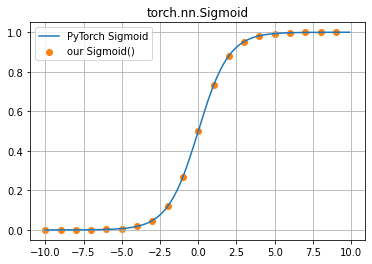

In [6]:
def sigmoid(x):
    """
    Activation function
    """
    return 1.0 / (1.0 + np.exp(-x))

x = np.arange(-10, 10, 0.1)
matplotlib.pyplot.plot(x, torch.nn.Sigmoid()(torch.from_numpy(x)).detach().numpy(), label="PyTorch Sigmoid")
matplotlib.pyplot.scatter(x[::10], sigmoid(x[::10]), color='C1', label="our Sigmoid()")
matplotlib.pyplot.grid()
matplotlib.pyplot.legend()
matplotlib.pyplot.title("torch.nn.Sigmoid")
pass


Setting learning rate to 0.05 based on prior experience.
error at step     0:   1.47e+00
error at step  1000:   2.33e-01
error at step  2000:   1.09e-01
error at step  3000:   6.98e-02
error at step  4000:   5.10e-02
error at step  5000:   4.00e-02
error at step  6000:   3.29e-02
error at step  7000:   2.79e-02
error at step  8000:   2.43e-02
error at step  9000:   2.14e-02
Final weights: [9.98578506 9.98589032]
Final bias:    -4.52752860008788


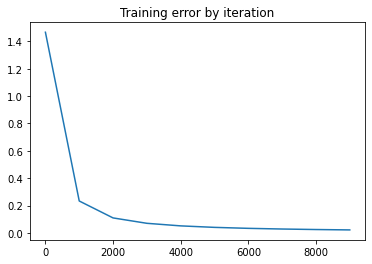

In [7]:
learning_rate = 0.05
print("\nSetting learning rate to {} based on prior experience.".format(learning_rate))

NUM_ITERATIONS = 10000

# pytorch is more sensitive about types, so we explicitly cast our integer input arrays as float64
inputs_tensor = torch.from_numpy(inputs.to_numpy(dtype=np.float64))
truth_tensor = torch.from_numpy(ground_truth.to_numpy(dtype=np.float64).reshape(-1, 1))

errors = dict()

# use PyTorch's implementation of our loss = abs(f0 - f)
loss = torch.nn.L1Loss(reduction='sum')

# use PyTorch's implementation of gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model.train()
x = inputs_tensor

for i in range(NUM_ITERATIONS):
    f = model(x)

    error = loss(f, truth_tensor)

    # erase memory of gradients at previous step
    optimizer.zero_grad()

    # compute gradient of loss function
    error.backward()

    # use computed gradient to update weights and bias
    optimizer.step()

    if i % (NUM_ITERATIONS / 10) == 0:
        print("error at step {:5d}: {:10.2e}".format(i, error.sum()))
        errors[i] = error.sum()

print("Final weights: {}".format(next(model.parameters()).detach().numpy().flatten()))
print("Final bias:    {}".format(list(model.parameters())[-1].item()))

lists = sorted(errors.items())
x_axis, y_axis = zip(*lists)
plt.plot(x_axis, y_axis)
plt.title("Training error by iteration")
plt.show()

In [8]:
model.eval()

predicted_output = model(inputs_tensor).detach().numpy()
predicted_output = pd.DataFrame(
    predicted_output,
    columns=["predicted output"],
    index=inputs.index)

print(pd.concat((
    inputs,
    ground_truth,
    predicted_output),
    axis=1))

               input 1  input 2  true output  predicted output
observation #                                                 
0                    0        0            0          0.010692
1                    0        1            1          0.995758
2                    1        0            1          0.995757
3                    1        1            1          1.000000
